In [1]:
# Import my code
#from tensorfactorization.poisson import *
from tensorfactorization.multiplicative import *
from tensorfactorization.poisson import *

In [2]:
import tensorly as tl
import numpy as np
import torch
import math
import time
import random
import matplotlib.pyplot as plt
from skimage import data

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

from dataclasses import dataclass, field
from typing import List

import copy # import copy so that we can do deep copys

import pickle # use pickle to save results to disk

In [3]:
x = np.array([1.0, 2.0, 3.0, 4.0])
G = np.diag(1.0/x)
G_inv = np.diag(x)
print(G_inv)
dF = np.array([1.0, 2.0, 3.0, 4.0])
print(np.sum(dF * G_inv@dF))
print(np.sum(dF * x * dF))

A = np.random.rand(2,3)
dF = np.random.rand(2, 3)
print(tl.sum(dF * A * dF))
#print(
step_size_modifiers = []
for i in range(3):
    step_size_modifiers.append([])
print(step_size_modifiers)

[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 4.]]
100.0
100.0
0.5868339027092577
[[], [], []]


In [4]:
tensor = tl.random.random_tensor((10, 10))
tl.context(tensor)
tl.set_backend('pytorch')
print(tl.get_backend())
torch.cuda.is_available()

pytorch


True

C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\__init__.py:206: RuntimeWarning: overflow encountered in exp
  return getattr(


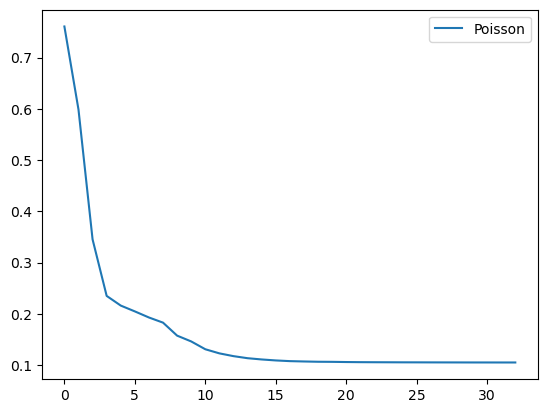

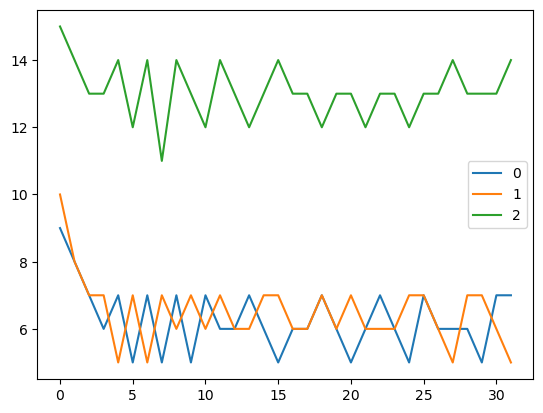

In [123]:
# Testing just poisson algo
tl.set_backend('numpy')
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise

start = time.time()
A_ns, RE_poisson, approx_poisson, step_size_modifiers = tensor_factorization_cp_poisson(X, F, max_iter=100, detailed=True, verbose=False)
end = time.time()
plt.plot(RE_poisson, label="Poisson")
plt.legend()
plt.show()

for n, modifiers in enumerate(step_size_modifiers):
    plt.plot(modifiers, label=n)
plt.legend()
plt.show()

C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\__init__.py:206: RuntimeWarning: overflow encountered in exp
  return getattr(
C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Poisson algorithm took 6.4189324378967285 seconds with 105 iterations and had final error of 25.767369394965097
Multiplicative algorithm took 4.418255090713501 seconds with 674 iterations and had final error of 25.68528964058915
Multiplicative Poisson algorithm took 7.118511199951172 seconds with 560 iterations and had final error of 25.787136093818976
Muliplicative algorithm was 1.4528206964302144 times faster in total
Muliplicative algorithm was 9.40142623747629 times faster per iteration
Muliplicative Poisson algorithm was 4.846766533700414 times faster per iteration


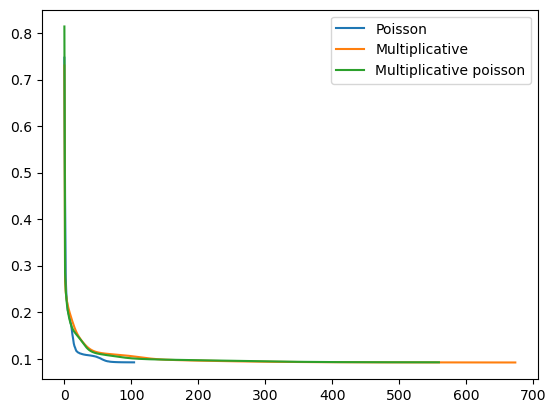

In [3]:
# Comparing on CPU
tl.set_backend('numpy')
dimensions = (300, 300, 3)
F = 4
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True)
noise = tl.random.random_tensor(dimensions) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative_poisson = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Multiplicative Poisson algorithm took " + str(time_multiplicative_poisson) + " seconds with " + str(len(RE_mult_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_mult_poisson)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
time_per_iteration_mult_poisson = time_multiplicative_poisson / (len(RE_mult_poisson) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")
print("Muliplicative Poisson algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult_poisson) + " times faster per iteration")
#print(tl.norm(A-tl.random.random_cp((4, 4, 4), 2, full=True)))
#plt.figure()
plt.plot(RE_poisson, label="Poisson")
plt.plot(RE_mult, label="Multiplicative")
plt.plot(RE_mult_poisson, label="Multiplicative poisson")
plt.legend()
plt.show()

Poisson algorithm took 0.49431729316711426 seconds with 57 iterations and had final error of tensor(24.4625, device='cuda:0')
Multiplicative algorithm took 0.40400099754333496 seconds with 354 iterations and had final error of tensor(24.1888, device='cuda:0')
Multiplicative Poisson algorithm took 0.23252534866333008 seconds with 154 iterations and had final error of tensor(24.4685, device='cuda:0')
Muliplicative algorithm was 1.2235546351939182 times faster in total
Muliplicative algorithm was 7.7127640397045205 times faster per iteration


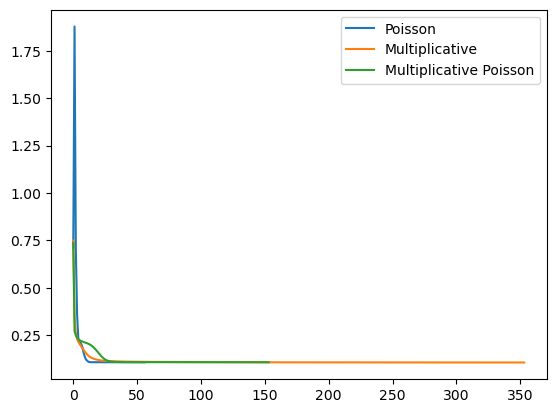

In [4]:
# Comparing on GPU with pytorch
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
dimensions = (300, 300, 3)
F = 2
noise_scaling = 0.1
true_solution = tl.random.random_cp(dimensions, F, full=True, **context)
noise = tl.random.random_tensor(dimensions, **context) * noise_scaling * tl.max(true_solution)
X = true_solution + noise
#A = tl.eye(4)
#print(A)
start = time.time()
_, RE_poisson, approx_poisson, _ = tensor_factorization_cp_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_poisson = end - start
start = time.time()
_, RE_mult, approx_mult = tensor_factorization_cp_multiplicative(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative = end - start
start = time.time()
_, RE_mult_poisson, approx_mult_poisson = tensor_factorization_cp_multiplicative_poisson(X, F, max_iter=1000, detailed=True, verbose=False)
end = time.time()
time_multiplicative_poisson = end - start
print("Poisson algorithm took " + str(time_poisson) + " seconds with " + str(len(RE_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_poisson)))
print("Multiplicative algorithm took " + str(time_multiplicative) + " seconds with " + str(len(RE_mult)) + " iterations and had final error of " + str(tl.norm(X - approx_mult)))
print("Multiplicative Poisson algorithm took " + str(time_multiplicative_poisson) + " seconds with " + str(len(RE_mult_poisson)) + " iterations and had final error of " + str(tl.norm(X - approx_mult_poisson)))
print("Muliplicative algorithm was " + str(time_poisson/time_multiplicative) + " times faster in total")
time_per_iteration_poisson = time_poisson / (len(RE_poisson) - 1)
time_per_iteration_mult = time_multiplicative / (len(RE_mult) - 1)
print("Muliplicative algorithm was " + str(time_per_iteration_poisson/time_per_iteration_mult) + " times faster per iteration")

plt.plot([value.cpu() for value in RE_poisson], label="Poisson")
plt.plot([value.cpu() for value in RE_mult], label="Multiplicative")
plt.plot([value.cpu() for value in RE_mult_poisson], label="Multiplicative Poisson")
plt.legend()
plt.show()

In [6]:
A = [2, 1, 2, ]
len(A)

3